In [66]:
import librosa
import pandas as pd
import numpy as np
import noisereduce as nr
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import re
import pyarabic.araby as araby
from pyarabic.normalize import normalize_hamza as normalize_text
import string
from IPython.display import Audio, display
import torch


### Loading audio

In [129]:
audio_path='Dataset/data/0afEfN_839.mp3'
y,sr=librosa.load(audio_path)

In [130]:
y

array([-0.09082846, -0.20175666, -0.26899123, ...,  0.47451907,
        0.46566895,  0.23209009], dtype=float32)

In [131]:
sr

22050

### Preprocessing and EDA

In [133]:
Audio(y, rate=sr)

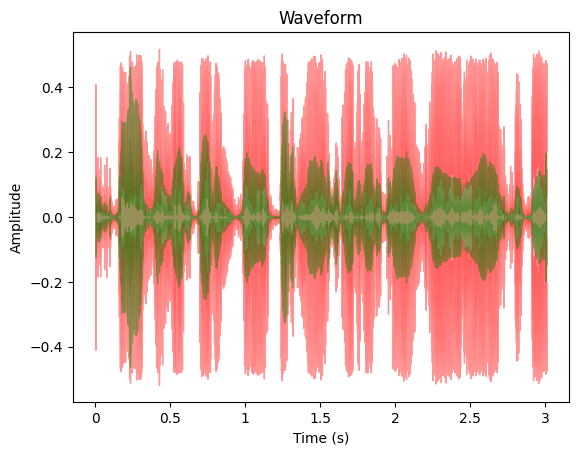

In [132]:
#Removing Noise and Plotting before and after
FIG_SIZE = (5, 5)
y_reduced=nr.reduce_noise(y, sr)
librosa.display.waveshow(y,  alpha=0.4,color='r')
librosa.display.waveshow(y_reduced,  alpha=0.4,color='g')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()
y_reduced=nr.reduce_noise(y, sr)
Audio(y_reduced, rate=sr)

In [109]:
print("Shape of Initial Data : "+ str(y.shape))
#Audio is Monophonic as it is from a sigle channel eliminating the complexity of processing/cleaning higher dimensional audios

Shape of Initial Data : (66327,)


Original Sampling Rate : 22050 Hz


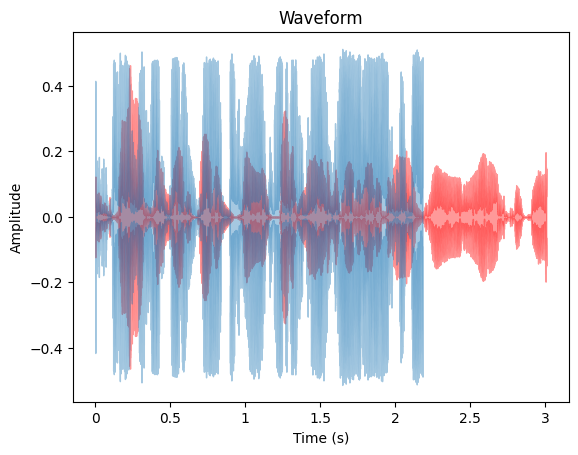

rate after downsampling : 16000


In [134]:
print("Original Sampling Rate : "+str(sr)+" Hz")
target_sr = 16000
y_downsampled=librosa.resample(y,orig_sr=sr,target_sr=target_sr)
Fig_SIZE = (10, 5)
librosa.display.waveshow(y_reduced,  alpha=0.4,color='r')
librosa.display.waveshow(y_downsampled,  alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()
print("rate after downsampling : "+ str(target_sr))
Audio(y_downsampled, rate=target_sr)

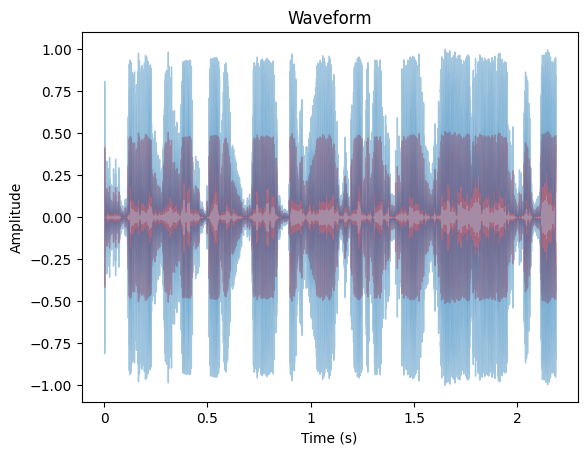

In [135]:
#Normalizing waveform
y_normalized=librosa.util.normalize(y_downsampled)
librosa.display.waveshow(y_downsampled,  alpha=0.4,color='r')
librosa.display.waveshow(y_normalized,  alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()
Audio(y_normalized, rate=target_sr)

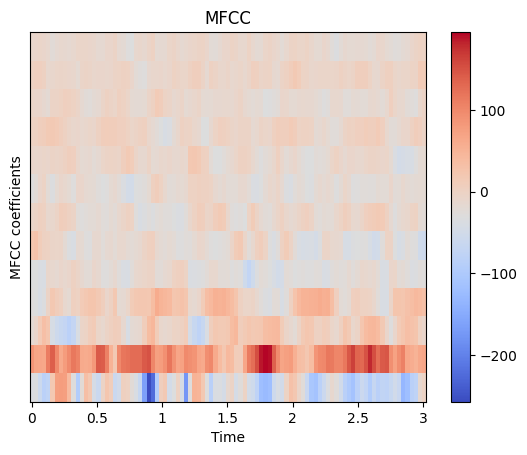

In [136]:
#Extracting MFCC and plotting
mfccs = librosa.feature.mfcc(y=y_normalized, sr=target_sr, n_mfcc=13)
FIG_SIZE=(10,5)
librosa.display.specshow(mfccs, sr=target_sr, x_axis='time')
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCC")
plt.show()


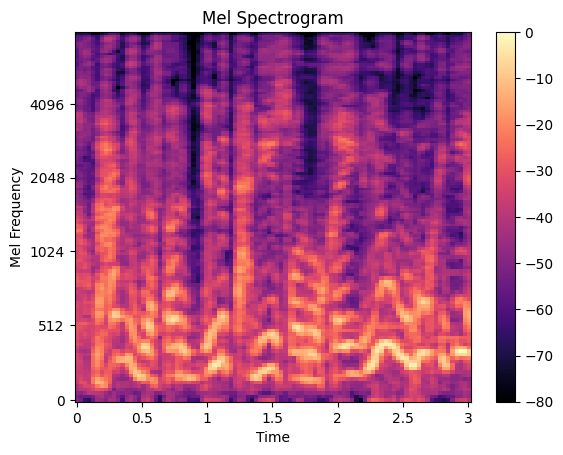

In [137]:
#MEL SPECTROGRAM
mel_spectrogram = librosa.feature.melspectrogram(y=y_normalized, sr=target_sr)
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=target_sr, x_axis='time', y_axis='mel')
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()
Audio(y_normalized, rate=target_sr)

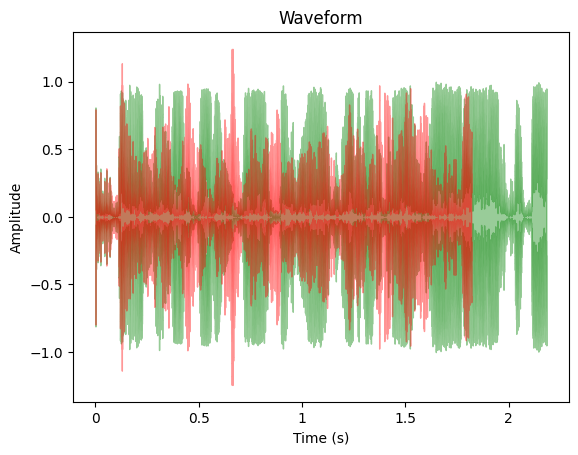

In [138]:
#Time masking
time_masked = librosa.effects.time_stretch(y_normalized, rate=1.2)
librosa.display.waveshow(y_normalized,  alpha=0.4,color='g')
librosa.display.waveshow(time_masked,  alpha=0.4,color='r')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()
Audio(time_masked, rate=target_sr)

### Processing Transcriptions 

In [115]:
import pandas as pd

In [116]:
df=pd.read_csv('Dataset/index.csv')

In [117]:
audio_path

'Dataset/data/0afEfN_839.mp3'

In [118]:
transcription = df[df['audio_file'] == audio_path.split('/')[-1]]['text'].iloc[0]
transcription

'ما حدش بيفترض إن التحديث والرقي\nليهم وجوه كتيرة،'

### Text to semantic modeling

In [119]:
from num2words import num2words
import re
# Function to replace numbers with words in a single sentence
def nlp_preprocessing(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace("\n", " ")

    # Replace the variants of 2lf
    sentence = re.sub(r'[إأآ]', 'ا', sentence)

    # Remove the punctuation and special characters
    sentence = re.sub(r'[^a-zA-Zء-ي\s\d]', '', sentence)  # Keep only Arabic, English letters, digits, and spaces

    pattern = r'[\u0617-\u061A\u064B-\u065F]'

    # Remove all the arabic special characters (تشكيل)
    sentence = re.sub(pattern, '', sentence)

    # Pattern to insert a space between Arabic and English (or vice versa)
    pattern = r'([a-zA-Z])([ء-ي])|([ء-ي])([a-zA-Z])'

    # Replace matches with the same characters separated by a space
    sentence = re.sub(pattern, r'\1\3 \2\4', sentence)
    # Replace multiple spaces with a single space
    sentence = re.sub(r'\s+', ' ', sentence)

    # Regular expression to find numbers in the sentence and replace them with words
    sentence = re.sub(r'\d+', lambda x: num2words(int(x.group()), lang='ar'), sentence)
    return sentence

# Apply the function to each sentence \in the array
modified_transcription = [nlp_preprocessing(transcription)]
#why when  running it once some patterns does not fully applied to the text?
modified_transcription = [nlp_preprocessing(transcription) ] 

In [120]:
modified_transcription

['ما حدش بيفترض ان التحديث والرقي ليهم وجوه كتيرة']

In [121]:
import string

# Define the vocabulary: add lowercase letters, digits, and special tokens
special_tokens = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']  # Special tokens
english_characters = list(string.ascii_lowercase + ' ')  # List of English characters
arabic_characters = list("ابتثجحخدذرزسشصضطظعغفقكلمنهويئءىةؤ")  # List of Arabic characters

# Combine all characters
characters = english_characters + arabic_characters
vocab = special_tokens + characters  # Combine special tokens and characters

# Build dictionaries for character-to-index and index-to-character
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = {idx: char for idx, char in enumerate(vocab)}

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

print(vocab)

Vocabulary size: 64
['<PAD>', '<UNK>', '<SOS>', '<EOS>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ئ', 'ء', 'ى', 'ة', 'ؤ']


In [122]:
char2idx

{'<PAD>': 0,
 '<UNK>': 1,
 '<SOS>': 2,
 '<EOS>': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29,
 ' ': 30,
 'ا': 31,
 'ب': 32,
 'ت': 33,
 'ث': 34,
 'ج': 35,
 'ح': 36,
 'خ': 37,
 'د': 38,
 'ذ': 39,
 'ر': 40,
 'ز': 41,
 'س': 42,
 'ش': 43,
 'ص': 44,
 'ض': 45,
 'ط': 46,
 'ظ': 47,
 'ع': 48,
 'غ': 49,
 'ف': 50,
 'ق': 51,
 'ك': 52,
 'ل': 53,
 'م': 54,
 'ن': 55,
 'ه': 56,
 'و': 57,
 'ي': 58,
 'ئ': 59,
 'ء': 60,
 'ى': 61,
 'ة': 62,
 'ؤ': 63}

In [123]:
idx2char

{0: '<PAD>',
 1: '<UNK>',
 2: '<SOS>',
 3: '<EOS>',
 4: 'a',
 5: 'b',
 6: 'c',
 7: 'd',
 8: 'e',
 9: 'f',
 10: 'g',
 11: 'h',
 12: 'i',
 13: 'j',
 14: 'k',
 15: 'l',
 16: 'm',
 17: 'n',
 18: 'o',
 19: 'p',
 20: 'q',
 21: 'r',
 22: 's',
 23: 't',
 24: 'u',
 25: 'v',
 26: 'w',
 27: 'x',
 28: 'y',
 29: 'z',
 30: ' ',
 31: 'ا',
 32: 'ب',
 33: 'ت',
 34: 'ث',
 35: 'ج',
 36: 'ح',
 37: 'خ',
 38: 'د',
 39: 'ذ',
 40: 'ر',
 41: 'ز',
 42: 'س',
 43: 'ش',
 44: 'ص',
 45: 'ض',
 46: 'ط',
 47: 'ظ',
 48: 'ع',
 49: 'غ',
 50: 'ف',
 51: 'ق',
 52: 'ك',
 53: 'ل',
 54: 'م',
 55: 'ن',
 56: 'ه',
 57: 'و',
 58: 'ي',
 59: 'ئ',
 60: 'ء',
 61: 'ى',
 62: 'ة',
 63: 'ؤ'}

In [124]:
def tokenize_text(text, char2idx, max_len=120, start_token=True, end_token=True):
    tokens = [char2idx.get(char, char2idx['<UNK>']) for char in text]

    if start_token:
        tokens.insert(0, char2idx['<SOS>'])
    if end_token:
        tokens.append(char2idx['<EOS>'])

    if max_len is not None:
        tokens = tokens[:max_len]  
        tokens += [char2idx['<PAD>']] * (max_len - len(tokens))  

    return tokens

# Example tokenization
sentence = transcription
tokens = tokenize_text(sentence, char2idx, max_len = 120)
print(tokens)

[2, 54, 31, 30, 36, 38, 43, 30, 32, 58, 50, 33, 40, 45, 30, 1, 55, 30, 31, 53, 33, 36, 38, 58, 34, 30, 57, 31, 53, 40, 51, 58, 1, 53, 58, 56, 54, 30, 57, 35, 57, 56, 30, 52, 33, 58, 40, 62, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [125]:
import tensorflow as tf
def TextDecoder(sentence):
    out = ''
    for token in sentence:
        if isinstance(token, tf.Tensor):
            token = token.numpy().item()
        char = idx2char[token]
        if char == '<EOS>':
            return out
        if not (char in special_tokens):
            out += char
    return out

TextDecoder(tokens)

'ما حدش بيفترض ن التحديث والرقيليهم وجوه كتيرة'

In [126]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')  
# Convert tokens (list of integers) back to a string using idx2char
sentence = ''.join([idx2char[token] for token in tokens if token in idx2char and idx2char[token] not in special_tokens])
embedding = model.encode(sentence)
print(embedding.shape)
print(embedding)


(512,)
[-1.63359903e-02  1.49260147e-03  3.27931158e-02  1.74303632e-02
 -4.92591001e-02  4.05649841e-02  1.64188556e-02 -6.43210672e-03
  3.13744284e-02  1.13308094e-02  5.09594753e-03  1.40913334e-02
 -1.78881381e-02  2.99182232e-03 -7.38872681e-03 -3.96706760e-02
  7.86353368e-03  2.60935854e-02 -5.66056510e-03 -2.49441760e-03
 -1.51243815e-02 -5.05268481e-03  2.55849063e-02 -1.37044443e-02
 -6.09893864e-03  1.45208358e-03 -1.38741070e-02  5.68808429e-03
 -1.56844128e-03 -1.52306529e-02 -2.71398015e-02  4.69765775e-02
  2.36607678e-02 -3.60733755e-02  4.48750518e-02 -1.52251907e-02
  2.65611778e-03 -1.32565415e-02  4.31380002e-03  6.06270507e-02
 -1.55234965e-03 -1.00358250e-02  1.31847933e-02  3.10600139e-02
  1.56331770e-02  1.69559917e-03 -3.66400667e-02  3.95355746e-02
  1.36324903e-02  1.16416523e-02 -1.21265426e-02  3.61268483e-02
  1.33090019e-02 -3.65103642e-03 -1.22614354e-02 -1.62048079e-02
  1.81783047e-02  3.09873582e-03  1.07388319e-02  3.05875726e-02
  6.89043524e-03  

In [127]:
embedding

array([-1.63359903e-02,  1.49260147e-03,  3.27931158e-02,  1.74303632e-02,
       -4.92591001e-02,  4.05649841e-02,  1.64188556e-02, -6.43210672e-03,
        3.13744284e-02,  1.13308094e-02,  5.09594753e-03,  1.40913334e-02,
       -1.78881381e-02,  2.99182232e-03, -7.38872681e-03, -3.96706760e-02,
        7.86353368e-03,  2.60935854e-02, -5.66056510e-03, -2.49441760e-03,
       -1.51243815e-02, -5.05268481e-03,  2.55849063e-02, -1.37044443e-02,
       -6.09893864e-03,  1.45208358e-03, -1.38741070e-02,  5.68808429e-03,
       -1.56844128e-03, -1.52306529e-02, -2.71398015e-02,  4.69765775e-02,
        2.36607678e-02, -3.60733755e-02,  4.48750518e-02, -1.52251907e-02,
        2.65611778e-03, -1.32565415e-02,  4.31380002e-03,  6.06270507e-02,
       -1.55234965e-03, -1.00358250e-02,  1.31847933e-02,  3.10600139e-02,
        1.56331770e-02,  1.69559917e-03, -3.66400667e-02,  3.95355746e-02,
        1.36324903e-02,  1.16416523e-02, -1.21265426e-02,  3.61268483e-02,
        1.33090019e-02, -